## Modelling for Forwards

### Preprocessing

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import numpy as np

final_df = pd.read_csv("plch_uncorr_elo_v2.csv")

# 1. Filter for "Att Mid / Wingers"
df_fw = final_df[final_df["Position"] == "Forwards"].copy()

df_fw

,Player,Birthdate,League,Club,Footed,Nationality,Position,Minutes,Goals,Assists,...,Carries into Penalty Area,Miscontrols,Dispossessed,Fouls Committed,Fouls Drawn,Offsides,Ball Recoveries,Aerials Won,overall,Elo
11,Diogo Jota,1996-12-04,PremierLeague,Liverpool,Right,Portugal,Forwards,1196,0.45,0.23,...,1.58,3.01,1.66,1.73,1.05,0.08,3.09,1.66,84,1993
13,Darwin Núñez,1999-06-24,PremierLeague,Liverpool,Right,Uruguay,Forwards,1133,0.40,0.16,...,0.95,1.91,1.67,2.14,1.11,0.95,3.26,1.59,80,1993
23,Kai Havertz,1999-06-11,PremierLeague,Arsenal,Left,Germany,Forwards,1875,0.43,0.14,...,0.86,2.11,1.10,1.82,1.10,0.67,1.97,3.02,82,1993
29,Gabriel Jesus,1997-04-03,PremierLeague,Arsenal,Right,Brazil,Forwards,608,0.44,0.00,...,1.63,1.92,1.92,2.07,1.48,1.33,4.14,1.33,80,1993
30,Eddie Nketiah,1999-05-30,PremierLeague,Crystal Palace,Right,England,Forwards,1034,0.26,0.09,...,1.22,3.05,1.48,2.70,2.52,0.44,2.26,1.83,74,1835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,Mustapha Bundu,1997-02-27,EFLChampionship,Plymouth Argyle,Right,Sierra Leone,Forwards,2302,0.39,0.23,...,0.74,2.54,1.09,1.72,1.13,0.59,3.56,2.78,69,1443
600,Michael Obafemi,2000-07-06,EFLChampionship,Plymouth Argyle,Right,Republic of Ireland,Forwards,1196,0.15,0.00,...,0.90,3.39,1.35,0.83,0.98,0.30,3.01,0.23,67,1443
602,Andre Gray,1991-06-26,EFLChampionship,Fatih Karagümrük SK,Right,Jamaica,Forwards,550,0.49,0.16,...,0.33,1.64,0.33,0.98,0.82,1.31,1.31,0.65,87,1603
610,Callum Robinson,1995-02-02,EFLChampionship,Cardiff City,Right,Republic of Ireland,Forwards,2023,0.53,0.04,...,0.76,2.00,1.20,0.27,1.02,0.93,2.67,0.49,69,1434


In [ ]:
# 2. Define target and input features //
target = "overall"
drop_cols = ["Player", "Birthdate", "League", "Club", "Nationality", "Footed", "Position", "Minutes", "Club_x", "Aerials Lost"]

forwards_features = [
    'Goals', 'Assists', 'npxG + xAG',                 # Scoring and expected involvement
    'Shots on Target', 'Goals/Shot',                  # Efficiency and quality of finishing
    'Average Shot Distance',                          # Shot selection
    'Touches (Att Pen)', 'Touches (Att 3rd)',         # Involvement in danger areas
    'Progressive Carries',                            # Beating defenders and directness
    'Carries into Penalty Area',                      # Penetration
    'Pass Completion %', 'Live-ball Passes',          # Linking play
    'SCA (Shot)', 'SCA (Take-On)', 'SCA (Live-ball Pass)', # All shot creation channels
    'GCA (Shot)', 'GCA (Take-On)', 'GCA (Live-ball Pass)', # All goal creation channels
    'Through Balls', 'Crosses',                       # Direct creativity
    'Offsides',                                       # Movement behind defense
    'Fouls Drawn',                                    # Provoking fouls, winning set pieces
    'Aerials Won',                                    # Headers, target man play
    'Miscontrols', 'Dispossessed',                    # Ball retention under pressure
    'Elo'                                             # Team/league context
]

In [3]:
X = df_fw.drop(columns=drop_cols + [target], errors="ignore")
X = X[forwards_features]
y = df_fw[target]
numeric_features = X.select_dtypes(include="number").columns.tolist()


# 3. Preprocessing pipeline // min-maxscaling for numeric features
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features)
])

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [4]:
# 5. Initiate method that will train and evaluate different models 

def evaluate_model(
    name,
    model,
    preprocessor_override=None,
    X_train_override=None,
    X_test_override=None,
    y_train_override=None,
    y_test_override=None
):
    # Use overrides or fall back to global variables
    X_train_local = X_train_override if X_train_override is not None else X_train
    X_test_local = X_test_override if X_test_override is not None else X_test
    y_train_local = y_train_override if y_train_override is not None else y_train
    y_test_local = y_test_override if y_test_override is not None else y_test
    preprocessor_local = preprocessor_override if preprocessor_override is not None else preprocessor

    # Define pipeline
    pipe = Pipeline([
        ("preprocess", preprocessor_local),
        ("regressor", model)
    ])

    # Fit and predict
    pipe.fit(X_train_local, y_train_local)
    y_pred = pipe.predict(X_test_local)

    # Cross-validation (on full data)
    cv_score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    mean_cv_mae = -np.mean(cv_score)

    return {
        "Model": name,
        "MAE": mean_absolute_error(y_test_local, y_pred),
        "RMSE": root_mean_squared_error(y_test_local, y_pred),
        "5-CV": mean_cv_mae,
        "R2": r2_score(y_test_local, y_pred),
        "Pipeline": pipe
    }

### Linear Models

In [5]:
results = []

# Lasso
results.append(evaluate_model("Lasso", LassoCV(cv=3, max_iter=5000, alphas=np.logspace(-3, 1, 100))))

# Get the trained Lasso pipeline
lasso_pipe = results[0]["Pipeline"]  

# Access the Lasso model and preprocessor
lasso_model = lasso_pipe.named_steps["regressor"]
scaler = lasso_pipe.named_steps["preprocess"]

# Get feature names from preprocessor
feature_names = scaler.transformers_[0][2]  # ['num', scaler, [feature list]]

# Get non-zero coefficients
import pandas as pd
coefs = pd.Series(lasso_model.coef_, index=feature_names)
non_zero_coefs = coefs[coefs != 0].sort_values(key=abs, ascending=False)

print("Non-zero Lasso Coefficients:")
print(non_zero_coefs)

Non-zero Lasso Coefficients:
Elo                  3.025102
Shots on Target      0.621157
Miscontrols         -0.484176
Goals                0.175911
Touches (Att Pen)    0.063617
dtype: float64


In [6]:
# Lasso + XGBoost
lasso = Pipeline([
    ("preprocessor", preprocessor),
    ('lasso', LassoCV(cv=5, max_iter=5000, alphas=np.logspace(-3, 1, 100)))
])
lasso.fit(X_train, y_train)
selected_features = np.array(numeric_features)[lasso.named_steps["lasso"].coef_ != 0]

selected_preprocessor = ColumnTransformer([
    ("num", StandardScaler(), selected_features.tolist())
])

results.append(evaluate_model(
    name="Lasso+XGBoost",
    model=XGBRegressor(
),
    preprocessor_override=selected_preprocessor,
    X_train_override=X_train[selected_features],
    X_test_override=X_test[selected_features],
    y_train_override=y_train,
    y_test_override=y_test
))

### Elastic Net with correlated features to target variable

In [74]:
# Select top k features with strongest correlation to target
from sklearn.feature_selection import SelectKBest, f_regression

# Feature selection
selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = selector.get_feature_names_out(input_features=X.columns)

# Train/test split
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X[selected_features], y, test_size=0.15
)

# Preprocessing and model
preprocessor_sel = ColumnTransformer([
    ("num", StandardScaler(), selected_features)
])
model = ElasticNetCV(cv=5, max_iter=5000)

pipeline = Pipeline([
    ("preprocess", preprocessor_sel),
    ("regressor", model)
])

# Fit and predict
pipeline.fit(X_train_sel, y_train_sel)
y_pred_sel = pipeline.predict(X_test_sel)

# Evaluate and store
results.append({
    "Model": "ElasticNet (Top15 SelectKBest)",
    "MAE": mean_absolute_error(y_test_sel, y_pred_sel),
    "RMSE": root_mean_squared_error(y_test_sel, y_pred_sel),
    "5-CV": -cross_val_score(pipeline, X[selected_features], y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test_sel, y_pred_sel),
    "Pipeline": pipeline
})

### Stacked Model

In [8]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline

# Define base and meta learners
base_model = make_pipeline(StandardScaler(), ElasticNetCV(cv=5, random_state=42))
meta_model = XGBRegressor(n_estimators=100)

# Wrap ElasticNet and XGBoost in stacking regressor
stacked_model = StackingRegressor(
    estimators=[("elasticnet", base_model)],
    final_estimator=meta_model,
    passthrough=True  # includes original features as well
)

# Train/test split stays the same
stacked_model.fit(X_train, y_train)
y_pred_stack = stacked_model.predict(X_test)

# Evaluate
results.append({
    "Model": "ElasticNet→XGBoost (Stacked)",
    "MAE": mean_absolute_error(y_test, y_pred_stack),
    "RMSE": root_mean_squared_error(y_test, y_pred_stack),
    "5-CV": cross_val_score(stacked_model, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_stack),
    "Pipeline": stacked_model
})

### Hyperparamater tuning for RF & XG

In [9]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def rf_objective(trial):
    # Hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }

    model = RandomForestRegressor(**params, n_jobs=-1)
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    
    score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    return -score.mean()  # Optuna minimizes

# Run the study
rf_study = optuna.create_study(direction="minimize")
rf_study.optimize(rf_objective, n_trials=100)

# Best model
best_rf = RandomForestRegressor(**rf_study.best_params)

[I 2025-06-12 16:21:30,812] A new study created in memory with name: no-name-f8ffc152-777c-4eb8-8b8a-9ba5e6044b16
[I 2025-06-12 16:21:34,418] Trial 0 finished with value: 3.8746286994047985 and parameters: {'n_estimators': 920, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 3.8746286994047985.
[I 2025-06-12 16:21:35,067] Trial 1 finished with value: 3.8222859418481376 and parameters: {'n_estimators': 573, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 3.8222859418481376.
[I 2025-06-12 16:21:35,355] Trial 2 finished with value: 4.772237192764252 and parameters: {'n_estimators': 247, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 3.8222859418481376.
[I 2025-06-12 16:21:35,595] Trial 3 finished with value: 4.797231857325242 and parameters: {'n_estimators': 198, 'max_depth': 16, 'min_samp

In [10]:
# Create pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_rf)
])

# Fit and predict
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

results.append({
    "Model": "RandomForest (Optuna)",
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "RMSE": root_mean_squared_error(y_test, y_pred_rf),
    "5-CV": - cross_val_score(rf_pipeline, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_rf),
    "Pipeline": rf_pipeline
})

In [11]:
from xgboost import XGBRegressor

def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
    }

    model = XGBRegressor(**params, n_jobs=-1)
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    
    score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    return -score.mean()

# Run the study
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=100)

# Best model
best_xgb = XGBRegressor(**xgb_study.best_params)

[I 2025-06-12 16:23:00,753] A new study created in memory with name: no-name-c528e903-855b-4918-a182-6377eea15864
[I 2025-06-12 16:23:02,217] Trial 0 finished with value: 4.0514643641880586 and parameters: {'n_estimators': 814, 'max_depth': 14, 'learning_rate': 0.01431425978756625, 'subsample': 0.9754652564208898, 'colsample_bytree': 0.6993477121086119, 'gamma': 0.013062678349876622, 'reg_alpha': 0.888329662874789, 'reg_lambda': 0.15777761752110908}. Best is trial 0 with value: 4.0514643641880586.
[I 2025-06-12 16:23:02,567] Trial 1 finished with value: 4.038500780378069 and parameters: {'n_estimators': 452, 'max_depth': 15, 'learning_rate': 0.0409288255922773, 'subsample': 0.7120378895980346, 'colsample_bytree': 0.5233285874539095, 'gamma': 3.2072515862729034, 'reg_alpha': 0.4009181894921975, 'reg_lambda': 0.06111947950085794}. Best is trial 1 with value: 4.038500780378069.
[I 2025-06-12 16:23:02,778] Trial 2 finished with value: 4.265403798421224 and parameters: {'n_estimators': 342,

In [12]:
# Create pipeline
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_xgb)
])

# Fit and predict
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

results.append({
    "Model": "XGBoost (Optuna)",
    "MAE": mean_absolute_error(y_test, y_pred_xgb),
    "RMSE": root_mean_squared_error(y_test, y_pred_xgb),
    "5-CV": -cross_val_score(xgb_pipeline, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_xgb),
    "Pipeline": rf_pipeline
})

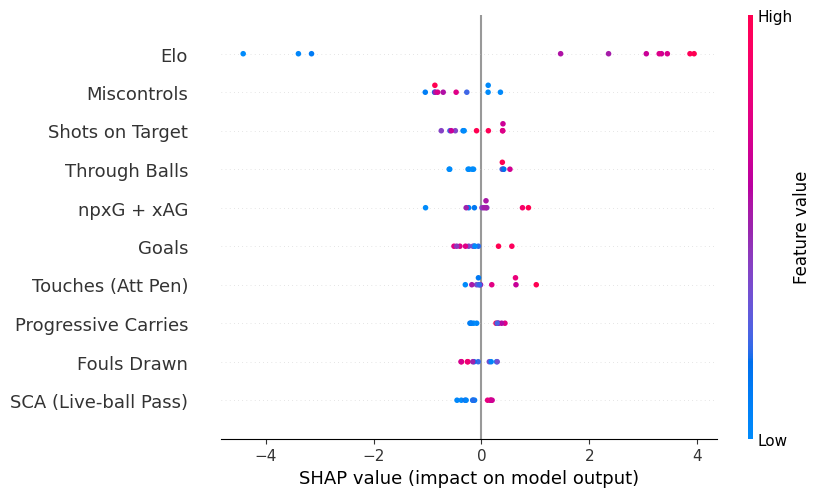

In [13]:
import shap
import numpy as np
import pandas as pd

# Extract model and transformed data
xgb_model = xgb_pipeline.named_steps["regressor"]
X_transformed = xgb_pipeline.named_steps["preprocessor"].transform(X_test)

# Extract feature names used in preprocessing
feature_names = xgb_pipeline.named_steps["preprocessor"].transformers_[0][2]

# Convert transformed data to DataFrame with proper column names
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values = explainer(X_transformed_df)

# Compute mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# Get indices of top 10 features
top_10_indices = np.argsort(mean_abs_shap)[-10:]

# Filter SHAP values to top 10 features
shap_values_top = shap_values[:, top_10_indices]

# Plot SHAP summary (beeswarm) for top 10 features
shap.plots.beeswarm(shap_values_top)


### Modelling Results 

In [75]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by MAE (ascending)
results_df_sorted = results_df.sort_values(by="R2", ascending=False)

# Display selected columns (optional)
display_cols = ["Model", "MAE", "RMSE", "5-CV", "R2"]
print(results_df_sorted[display_cols])

                             Model       MAE      RMSE      5-CV        R2
52  ElasticNet (Top15 SelectKBest)  2.029992  2.433911  3.910827  0.794261
61  ElasticNet (Top15 SelectKBest)  2.126571  2.757405  3.910827  0.761164
22  ElasticNet (Top15 SelectKBest)  2.370676  2.868715  3.910827  0.758073
37  ElasticNet (Top15 SelectKBest)  2.162755  2.685523  3.910827  0.711232
19  ElasticNet (Top15 SelectKBest)  2.234797  2.672765  3.910827  0.707385
..                             ...       ...       ...       ...       ...
23  ElasticNet (Top15 SelectKBest)  4.002370  5.183817  3.910827  0.064584
40  ElasticNet (Top15 SelectKBest)  3.605734  4.080102  3.910827  0.037134
9   ElasticNet (Top15 SelectKBest)  3.757283  5.448978  3.910827  0.027961
45  ElasticNet (Top15 SelectKBest)  4.229407  6.443071  3.910827 -0.133881
1                    Lasso+XGBoost  4.688320  5.503329  4.598514 -0.140935

[63 rows x 5 columns]


### Model Saving & Shap Plots

In [76]:
import joblib

# Get the best model (lowest MAE)
best_model = results_df_sorted.iloc[0]["Pipeline"]

# Save to disk
joblib.dump(best_model, "best_model_fw.joblib")

['best_model_fw.joblib']

In [77]:
elastic = best_model.named_steps['elasticnetcv'] if 'elasticnetcv' in best_model.named_steps else best_model[-1]

# Get the StandardScaler (inside the ColumnTransformer)
preprocessor = best_model.named_steps['preprocess']

# 1. Get the list of actually used features:
feature_names = preprocessor.transformers_[0][2]  # This gets the feature names for 'num'

# 2. Coefficients from the model
coefs = elastic.coef_

# 3. Make sure lengths match
print(f"Feature names: {len(feature_names)}, Coefs: {len(coefs)}")

# 4. Now make the DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
}).sort_values(by='coefficient', key=abs, ascending=False)

print(importance_df)


Feature names: 20, Coefs: 20
                      feature  coefficient
19                        Elo     2.562516
18                Miscontrols    -0.823495
6           Touches (Att Pen)     0.512794
0                       Goals     0.483867
4                  Goals/Shot     0.371422
3             Shots on Target     0.346897
16              Through Balls     0.343692
1                     Assists     0.278788
13       SCA (Live-ball Pass)     0.203663
10          Pass Completion %     0.183391
5       Average Shot Distance    -0.037659
9   Carries into Penalty Area     0.035870
7           Touches (Att 3rd)     0.000000
8         Progressive Carries     0.000000
11           Live-ball Passes     0.000000
12                 SCA (Shot)     0.000000
14              GCA (Take-On)    -0.000000
15       GCA (Live-ball Pass)    -0.000000
17                    Crosses    -0.000000
2                  npxG + xAG     0.000000


In [78]:
# Transform X_train with your pipeline up to the estimator
X_proc = best_model.named_steps['preprocess'].transform(X_train[feature_names])

/Users/ghalichraibi/anaconda3/lib/python3.11/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


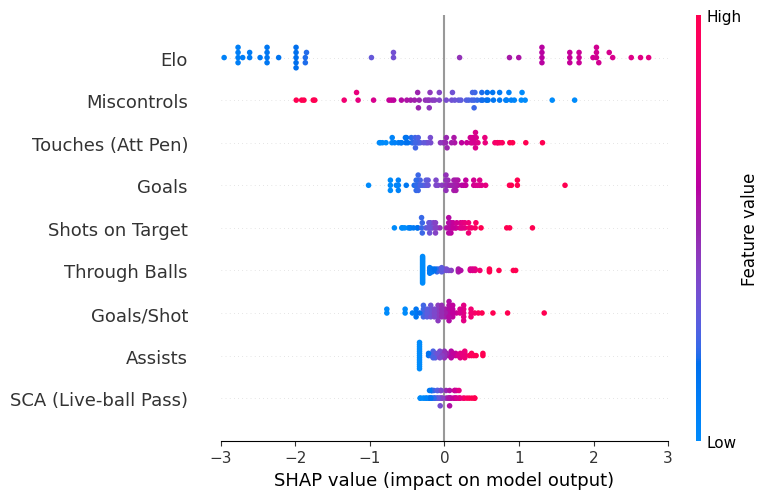

In [79]:
import shap
import matplotlib.pyplot as plt

explainer = shap.LinearExplainer(elastic, X_proc, feature_perturbation="interventional")
shap_values = explainer(X_proc)

plt.figure(figsize=(6, 8))  # Adjust for better horizontal space if needed
shap.summary_plot(
    shap_values, 
    features=X_proc, 
    feature_names=feature_names, 
    show=False, 
    max_display=9  # <-- Only show top 6 features
)
plt.xlim(-3, 3)
plt.show()
